## Import required modules


In [1]:
from typing import List, Tuple
from pathlib import Path
import os

import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    RandomizedSearchCV,
    validation_curve,
    TimeSeriesSplit,
)
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import GridSearchCV

sns.set_theme()

In [2]:
# Initialize file paths / constants
yfin_data_dir = os.path.join(Path().cwd(), "yfin_data")

## Helper Functions


In [3]:
def plot_chart_sma(
    input_df: pd.DataFrame,
    ticker: str,
    start_dte: str,
    end_dte: str,
    slow: int,
    fast: int,
):
    df = input_df.copy()
    start = dt.datetime.strptime(start_dte, "%Y-%m-%d")
    end = dt.datetime.strptime(end_dte, "%Y-%m-%d")

    fig = plt.figure(facecolor="white", figsize=(20, 10))

    ax0 = plt.subplot2grid((6, 4), (1, 0), rowspan=4, colspan=4)
    ax0.plot(
        df[df["symbol"] == ticker].loc[
            start:end, ["Close", f"SMA_{fast}", f"SMA_{slow}"]
        ]
    )
    # ax0.set_facecolor("black")
    ax0.legend(
        ["Close", f"SMA_{fast}", f"SMA_{slow}"], ncol=3, loc="upper left", fontsize=15
    )
    plt.title(f"{ticker} Stock Price, Slow and Fast Moving Average", fontsize=20)

    ax1 = plt.subplot2grid((6, 4), (5, 0), rowspan=1, colspan=4, sharex=ax0)
    ax1.plot(df[df["symbol"] == ticker].loc[start:end, ["SMA_ratio"]], color="blue")
    ax1.legend(["SMA_Ratio"], ncol=3, loc="upper left", fontsize=12)
    ax1.set_facecolor("silver")
    plt.subplots_adjust(
        left=0.09, bottom=0.09, right=1, top=0.95, wspace=0.20, hspace=0
    )
    plt.show()

## Import / Load Data


In [4]:
# Obtain list of SPY companies


def get_tickers(url: str) -> List[str]:
    """
    Generates the list of tickers from provided URL

    Args:
        url (str): URL containing tickers (wikipedia)

    Returns:
        List[str]: List of tickers in S&P 500
    """

    r = requests.get(url)
    soup = BeautifulSoup(r.text, "lxml")
    table = soup.find("table", {"class": "wikitable sortable"})

    tickers = []

    for rows in table.find_all("tr")[1:]:
        ticker = rows.find_all("td")[0].text.strip()
        tickers.append(ticker)

    return tickers


tickers = get_tickers("https://en.wikipedia.org/wiki/S%26P_100")
print(tickers)

['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM']


In [5]:
def get_yfin_data(
    tickers: List[str], start_dte: str, end_dte: str
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Retrieves stock data from Yahoo Finance
    - High
    - Low
    - Open
    - Close
    - Volume
    - AdjClose

    Args:
        tickers (List[str]): List of tickers to retrieve data
        start_dte (str): YYYY-MM-DD
        end_dte (str): YYYY-MM-DD

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, List[str]]: _description_
    """
    all_data = pd.DataFrame()
    test_data = pd.DataFrame()
    no_data = []

    for ticker in tickers:
        try:

            # Check if data is present, else download data
            if f"{ticker}.csv" in os.listdir(yfin_data_dir):
                print(f"Ticker data found for: {ticker}")
                test_data = pd.read_csv(
                    os.path.join(yfin_data_dir, f"{ticker}.csv"),
                    index_col=0,
                    parse_dates=True,
                )
            else:
                print(f"Downloading data for: {ticker}")
                test_data = yf.download(ticker, start=start_dte, end=end_dte)
                test_data["symbol"] = ticker
                test_data.to_csv(os.path.join(yfin_data_dir, f"{ticker}.csv"))
            all_data = pd.concat([all_data, test_data])
        except:
            print(f"no data for: {ticker}")
            no_data.append(ticker)
        # clear_output(wait = True)

    return all_data, test_data, no_data


all_data, test_data, no_data = get_yfin_data(
    tickers, "1990-01-01", dt.datetime.today().strftime("%Y-%m-%d")
)

Ticker data found for: AAPL
Ticker data found for: ABBV
Ticker data found for: ABT
Ticker data found for: ACN
Ticker data found for: ADBE
Ticker data found for: AIG
Ticker data found for: AMD
Ticker data found for: AMGN
Ticker data found for: AMT
Ticker data found for: AMZN
Ticker data found for: AVGO
Ticker data found for: AXP
Ticker data found for: BA
Ticker data found for: BAC
Ticker data found for: BK
Ticker data found for: BKNG
Ticker data found for: BLK
Ticker data found for: BMY
Ticker data found for: BRK.B
Ticker data found for: C
Ticker data found for: CAT
Ticker data found for: CHTR
Ticker data found for: CL
Ticker data found for: CMCSA
Ticker data found for: COF
Ticker data found for: COP


/var/folders/5_/5031yk8j46l_7pk431n48pyw0000gn/T/ipykernel_14717/2283183043.py:41: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_data = pd.concat([all_data, test_data])
/var/folders/5_/5031yk8j46l_7pk431n48pyw0000gn/T/ipykernel_14717/2283183043.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, test_data])


Ticker data found for: COST
Ticker data found for: CRM
Ticker data found for: CSCO
Ticker data found for: CVS
Ticker data found for: CVX
Ticker data found for: DE
Ticker data found for: DHR
Ticker data found for: DIS
Ticker data found for: DOW
Ticker data found for: DUK
Ticker data found for: EMR
Ticker data found for: F
Ticker data found for: FDX
Ticker data found for: GD
Ticker data found for: GE
Ticker data found for: GILD
Ticker data found for: GM
Ticker data found for: GOOG
Ticker data found for: GOOGL
Ticker data found for: GS
Ticker data found for: HD
Ticker data found for: HON
Ticker data found for: IBM
Ticker data found for: INTC
Ticker data found for: INTU
Ticker data found for: JNJ
Ticker data found for: JPM
Ticker data found for: KHC
Ticker data found for: KO
Ticker data found for: LIN
Ticker data found for: LLY
Ticker data found for: LMT
Ticker data found for: LOW
Ticker data found for: MA
Ticker data found for: MCD
Ticker data found for: MDLZ
Ticker data found for: MDT
Ti

In [6]:
# Preview loaded data
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL
...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM


## Generate Technical Indicators


### Simple Moving Average


In [7]:
def sma(stocks_data: pd.DataFrame, slow: int = 15, fast: int = 5) -> pd.DataFrame:
    """
    Generates simple moving average technical indiacator

    Args:
        stocks_data (pd.DataFrame): Input data using Close Data
        slow (int, optional): slower moving average window. Defaults to 15.
        fast (int, optional): faster moving average window. Defaults to 5.

    Returns:
        pd.DataFrame: _description_
    """

    data = stocks_data.copy()
    data[f"SMA_{fast}"] = data.groupby("symbol")["Close"].transform(
        lambda x: x.rolling(window=fast).mean()
    )
    data[f"SMA_{slow}"] = data.groupby("symbol")["Close"].transform(
        lambda x: x.rolling(window=slow).mean()
    )
    data["SMA_ratio"] = data[f"SMA_{slow}"] / data[f"SMA_{fast}"]
    print(type(data))

    return data


all_data = sma(all_data)
all_data.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio
Date,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN


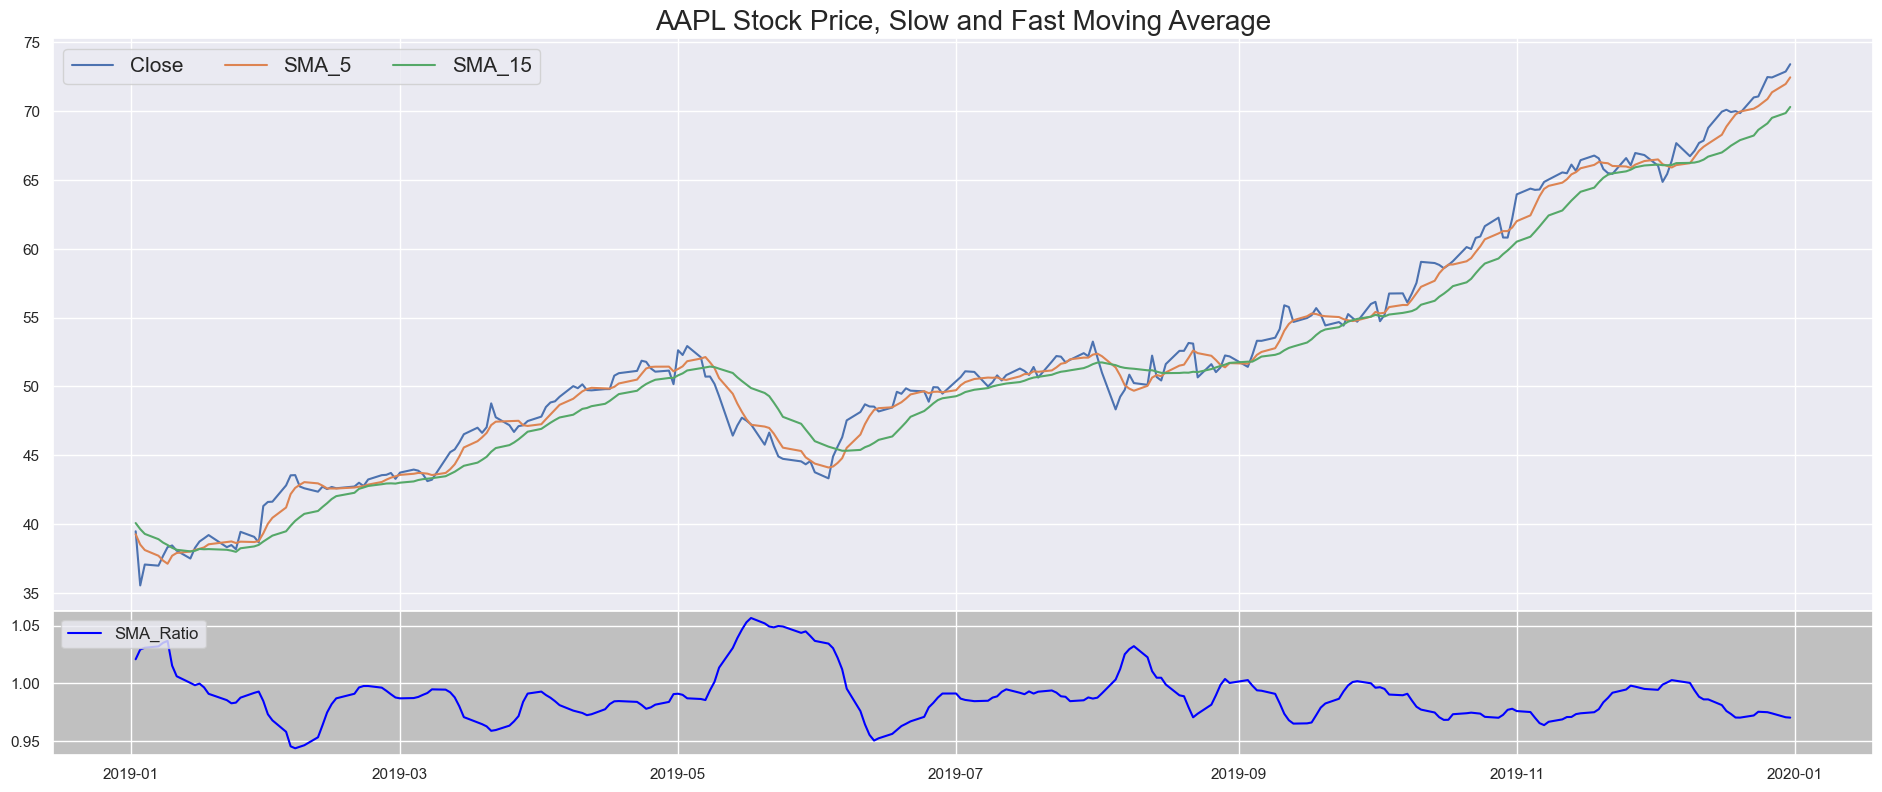

In [8]:
plot_chart_sma(all_data, "AAPL", "2019-01-01", "2020-01-01", 15, 5)

### Simple Moving Average Volume


In [9]:
def sma_vol(stocks_data: pd.DataFrame, slow: int = 15, fast: int = 5) -> pd.DataFrame:

    df = stocks_data.copy()
    df[f"SMA_{fast}_Volume"] = df.groupby("symbol")["Volume"].transform(
        lambda x: x.rolling(window=fast).mean()
    )
    df[f"SMA_{slow}_Volume"] = df.groupby("symbol")["Volume"].transform(
        lambda x: x.rolling(window=slow).mean()
    )
    df["SMA_Volume_Ratio"] = df[f"SMA_{fast}_Volume"] / df[f"SMA_{slow}_Volume"]

    return df


all_data = sma_vol(all_data)

In [10]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,SMA_5_Volume,SMA_15_Volume,SMA_Volume_Ratio
Date,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,167518400.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM,112.580000,113.686000,1.009824,13551540.0,1.595353e+07,0.849439
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM,111.794000,113.323333,1.013680,13814100.0,1.572603e+07,0.878422
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM,111.066000,113.030000,1.017683,13818940.0,1.554827e+07,0.888777


### Wilder's Smoothing


In [11]:
def wilder_smoothing(input_df: pd.DataFrame, periods) -> pd.DataFrame:
    df = input_df.copy()
    start = np.where(~np.isnan(df))[0][0]  # Check if np.nan is present in beginning
    wilder = np.array([np.nan] * len(df))
    wilder[start + periods - 1] = df[start : (start + periods)].mean()  # SMA
    for i in range(start + periods, len(df)):
        wilder[i] = (
            wilder[i - 1] * (periods - 1) + df[i]
        ) / periods  # wilder smoothing
    return wilder

### Average True Range


In [12]:
def atr(stocks_data: pd.DataFrame, slow: int, fast: int) -> pd.DataFrame:
    df = stocks_data.copy()
    df["prev_close"] = df.groupby("symbol")["Close"].shift(1)
    df["TR"] = np.maximum(
        (df["High"] - df["Low"]),
        np.maximum(
            abs(df["High"] - df["prev_close"]), abs(df["prev_close"] - df["Low"])
        ),
    )

    for symbol in df["symbol"].unique():
        tr_data = df[df["symbol"] == symbol].copy()
        df.loc[df["symbol"] == symbol, f"ATR_{fast}"] = wilder_smoothing(df["TR"], fast)
        df.loc[df["symbol"] == symbol, f"ATR_{slow}"] = wilder_smoothing(df["TR"], slow)

    df["ATR_Ratio"] = df[f"ATR_{fast}"] / df[f"ATR_{slow}"]

    return df

### Stochastic Oscillators


In [13]:
def stochastic_osc(
    stock_data: pd.DataFrame, slow: int = 15, fast: int = 5
) -> pd.DataFrame:

    df = stock_data.copy()
    df[f"Lowest_{fast}D"] = df.groupby("symbol")["Low"].transform(
        lambda x: x.rolling(window=fast).min()
    )
    df[f"High_{fast}D"] = df.groupby("symbol")["High"].transform(
        lambda x: x.rolling(window=fast).max()
    )

    df[f"Lowest_{slow}D"] = df.groupby("symbol")["Low"].transform(
        lambda x: x.rolling(window=slow).min()
    )
    df[f"High_{slow}D"] = df.groupby("symbol")["High"].transform(
        lambda x: x.rolling(window=slow).max()
    )

    df[f"Stochastic_{fast}"] = (
        (df["Close"] - df[f"Lowest_{fast}D"])
        / (df[f"High_{fast}D"] - df[f"Lowest_{fast}D"])
    ) * 100
    df[f"Stochastic_{slow}"] = (
        (df["Close"] - df[f"Lowest_{slow}D"])
        / (df[f"High_{slow}D"] - df[f"Lowest_{slow}D"])
    ) * 100

    df[f"Stochastic_%D_{fast}"] = df[f"Stochastic_{fast}"].rolling(window=fast).mean()
    df[f"Stochastic_%D_{slow}"] = df[f"Stochastic_{slow}"].rolling(window=slow).mean()

    df["Stochastic_Ratio"] = df[f"Stochastic_%D_{fast}"] / df[f"Stochastic_%D_{slow}"]

    return df

In [14]:
all_data = stochastic_osc(all_data)
all_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,SMA_Volume_Ratio,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,0.3125,0.345982,NaN,NaN,80.001228,NaN,NaN,NaN,NaN


In [15]:
all_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,SMA_Volume_Ratio,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,0.312500,0.345982,NaN,NaN,80.001228,NaN,NaN,NaN,NaN
1990-01-09,0.339286,0.339286,0.330357,0.335938,0.265727,86139200,AAPL,0.336607,NaN,NaN,...,NaN,0.330357,0.345982,NaN,NaN,35.718536,NaN,NaN,NaN,NaN
1990-01-10,0.335938,0.335938,0.319196,0.321429,0.254250,199718400,AAPL,0.333929,NaN,NaN,...,NaN,0.319196,0.345982,NaN,NaN,8.336551,NaN,NaN,NaN,NaN
1990-01-11,0.323661,0.323661,0.308036,0.308036,0.243656,211052800,AAPL,0.328349,NaN,NaN,...,NaN,0.308036,0.341518,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
1990-01-12,0.305804,0.310268,0.301339,0.308036,0.243656,171897600,AAPL,0.322545,NaN,NaN,...,NaN,0.301339,0.339286,NaN,NaN,17.648297,NaN,28.340922,NaN,NaN


### Relative Strength Index (RSI)


In [16]:
def rsi(stocks_data: pd.DataFrame, slow: int = 15, fast: int = 5) -> pd.DataFrame:
    """
    Generates RSI indicator based on specified fast and slow windows

    Args:
        stocks_data (pd.DataFrame):
        slow (int): _description_
        fast (int): _description_

    Returns:
        pd.DataFrame: _description_
    """
    df = stocks_data.copy()
    df["Diff"] = df.groupby("symbol")["Close"].transform(lambda x: x.diff())
    df["Up"] = df["Diff"]
    df.loc[(df["Up"] < 0), "Up"] = 0

    df["Down"] = df["Diff"]
    df.loc[(df["Down"] > 0), "Diff"] = 0
    df["Down"] = abs(df["Down"])

    df[f"avg_{fast}Up"] = df.groupby("symbol")["Up"].transform(
        lambda x: x.rolling(window=fast).mean()
    )
    df[f"avg_{fast}Down"] = df.groupby("symbol")["Down"].transform(
        lambda x: x.rolling(window=fast).mean()
    )

    df[f"avg_{slow}Up"] = df.groupby("symbol")["Up"].transform(
        lambda x: x.rolling(window=slow).mean()
    )
    df[f"avg_{slow}Down"] = df.groupby("symbol")["Down"].transform(
        lambda x: x.rolling(window=slow).mean()
    )

    df[f"RS_{fast}"] = df[f"avg_{fast}Up"] / df[f"avg_{fast}Down"]
    df[f"RS_{slow}"] = df[f"avg_{slow}Up"] / df[f"avg_{slow}Down"]

    df[f"RSI_{fast}"] = 100 - (100 / (1 + df[f"RS_{fast}"]))
    df[f"RSI_{slow}"] = 100 - (100 / (1 + df[f"RS_{slow}"]))

    df["RSI_Ratio"] = df[f"RSI_{fast}"] / df[f"RSI_{slow}"]

    return df


all_data = rsi(all_data)

In [17]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,Down,avg_5Up,avg_5Down,avg_15Up,avg_15Down,RS_5,RS_15,RSI_5,RSI_15,RSI_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,0.002232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,0.001117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,0.001116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,0.002232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM,112.580000,113.686000,1.009824,...,1.239998,0.236000,0.910001,0.446667,1.354668,0.259341,0.329725,20.593361,24.796460,0.830496
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM,111.794000,113.323333,1.013680,...,0.889999,0.066000,0.918001,0.446667,1.256002,0.071896,0.355626,6.707346,26.233367,0.255680
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM,111.066000,113.030000,1.017683,...,0.930000,0.066000,0.860001,0.446667,1.186668,0.076745,0.376405,7.127462,27.346946,0.260631


### Moving Average Convergence Divergence (MACD)


In [18]:
def macd(stocks_data: pd.DataFrame, slow: int = 26, fast: int = 12) -> pd.DataFrame:
    df = stocks_data.copy()

    df[f"{fast}Ewm"] = df.groupby("symbol")["Close"].transform(
        lambda x: x.ewm(span=fast, adjust=False).mean()
    )
    df[f"{slow}Ewm"] = df.groupby("symbol")["Close"].transform(
        lambda x: x.ewm(span=slow, adjust=False).mean()
    )
    df["MACD"] = df[f"{slow}Ewm"] - df[f"{fast}Ewm"]

    return df

In [19]:
all_data = macd(all_data)
all_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,avg_15Up,avg_15Down,RS_5,RS_15,RSI_5,RSI_15,RSI_Ratio,12Ewm,26Ewm,MACD
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332589,0.332589,0.000000
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332932,0.332754,-0.000178
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333395,0.332990,-0.000405
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333958,0.333291,-0.000667
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334777,0.333735,-0.001042


In [20]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,avg_15Up,avg_15Down,RS_5,RS_15,RSI_5,RSI_15,RSI_Ratio,12Ewm,26Ewm,MACD
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332589,0.332589,0.000000
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332932,0.332754,-0.000178
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333395,0.332990,-0.000405
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333958,0.333291,-0.000667
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334777,0.333735,-0.001042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,113.300003,113.300003,110.540001,110.930000,110.930000,13606800,XOM,112.580000,113.686000,1.009824,...,0.446667,1.354668,0.259341,0.329725,20.593361,24.796460,0.830496,113.438139,114.790552,1.352413
2024-06-13,110.839996,110.860001,109.720001,110.040001,110.040001,14466900,XOM,111.794000,113.323333,1.013680,...,0.446667,1.256002,0.071896,0.355626,6.707346,26.233367,0.255680,112.915349,114.438659,1.523311
2024-06-14,110.019997,110.209999,108.589996,109.110001,109.110001,13313400,XOM,111.066000,113.030000,1.017683,...,0.446667,1.186668,0.076745,0.376405,7.127462,27.346946,0.260631,112.329910,114.043944,1.714033


In [21]:
all_data.tail(20)

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,avg_15Up,avg_15Down,RS_5,RS_15,RSI_5,RSI_15,RSI_Ratio,12Ewm,26Ewm,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-21,118.400002,119.449997,117.779999,117.849998,117.849998,14495000,XOM,118.522000,117.462000,0.991057,...,0.395333,0.818667,0.517375,0.482899,34.096693,32.564528,1.047050,118.142286,117.845924,-0.296362
2024-05-22,117.459999,117.459999,114.959999,115.480003,115.480003,17879300,XOM,117.902000,117.425334,0.995957,...,0.395333,0.827333,0.266566,0.477841,21.046362,32.333705,0.650911,117.732704,117.670670,-0.062034
2024-05-23,115.599998,117.510002,113.360001,113.510002,113.510002,15979800,XOM,117.030000,117.243334,1.001823,...,0.381333,0.944667,0.224050,0.403670,18.304016,28.758177,0.636480,117.083057,117.362473,0.279415
2024-05-24,114.839996,115.080002,113.040001,113.419998,113.419998,12211400,XOM,115.786000,117.071334,1.011101,...,0.381333,0.934667,0.000000,0.407989,0.000000,28.976695,0.000000,116.519510,117.070438,0.550928
2024-05-28,113.519997,115.110001,113.070000,114.860001,114.860001,13978300,XOM,115.024001,116.945334,1.016704,...,0.427334,0.980667,0.215247,0.435758,17.712197,30.350381,0.583591,116.264201,116.906701,0.642501
2024-05-29,114.529999,114.550003,112.809998,113.629997,113.629997,13902000,XOM,114.180000,116.776000,1.022736,...,0.427334,1.024001,0.202817,0.417318,16.861838,29.444190,0.572671,115.858939,116.663983,0.805044
2024-05-30,113.269997,114.129997,112.959999,113.989998,113.989998,14692000,XOM,113.881999,116.632000,1.024148,...,0.451334,1.046667,0.353634,0.431210,26.124807,30.129058,0.867097,115.571409,116.465910,0.894500
2024-05-31,114.120003,117.489998,113.989998,117.260002,117.260002,29037400,XOM,114.631999,116.553334,1.016761,...,0.516667,1.112001,0.793427,0.464628,44.240817,31.723292,1.394585,115.831193,116.524731,0.693538
2024-06-03,116.300003,116.360001,113.760002,114.449997,114.449997,19589300,XOM,114.837999,116.319333,1.012899,...,0.516667,1.267334,0.556531,0.407680,35.754577,28.961137,1.234571,115.618701,116.371047,0.752346


### Bollinger Bands


In [22]:
def bollinger_bands(stock_data: pd.DataFrame, duration: str = "medium") -> pd.DataFrame:

    if duration not in ["short", "medium", "long"]:
        raise ValueError("duration must be 'short', 'medium' or 'long'")

    std_constant = 0

    if duration == "short":
        std_constant = 1.5
        periods = 10
    elif duration == "long":
        std_constant = 2.5
        periods = 50
    else:
        # Medium
        std_constant = 2
        periods = 20

    df = stock_data.copy()
    df[f"{periods}_MA"] = df.groupby("symbol")["Close"].transform(
        lambda x: x.rolling(window=periods).mean()
    )
    df[f"{periods}_SD"] = df.groupby("symbol")["Close"].transform(
        lambda x: x.rolling(window=periods).std()
    )
    df[f"bollinger_upper"] = df[f"{periods}_MA"] + std_constant * df[f"{periods}_SD"]
    df[f"bollinger_lower"] = df[f"{periods}_MA"] - std_constant * df[f"{periods}_SD"]

    return df

In [23]:
all_data = bollinger_bands(all_data, "medium")
all_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,RSI_5,RSI_15,RSI_Ratio,12Ewm,26Ewm,MACD,20_MA,20_SD,bollinger_upper,bollinger_lower
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,0.332589,0.332589,0.000000,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,0.332932,0.332754,-0.000178,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,0.333395,0.332990,-0.000405,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,NaN,0.333958,0.333291,-0.000667,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,NaN,NaN,0.334777,0.333735,-0.001042,NaN,NaN,NaN,NaN


## Rate of Change


In [24]:
def rate_of_change(stock_data: pd.DataFrame, periods: int = 15) -> pd.DataFrame:

    df = stock_data.copy()
    df["RC"] = df.groupby("symbol")["Close"].transform(
        lambda x: x.pct_change(periods=periods)
    )
    return df

In [25]:
all_data = rate_of_change(all_data)
all_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,RSI_15,RSI_Ratio,12Ewm,26Ewm,MACD,20_MA,20_SD,bollinger_upper,bollinger_lower,RC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.332589,0.332589,0.000000,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.332932,0.332754,-0.000178,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.333395,0.332990,-0.000405,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000,AAPL,NaN,NaN,NaN,...,NaN,NaN,0.333958,0.333291,-0.000667,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800,AAPL,0.335938,NaN,NaN,...,NaN,NaN,0.334777,0.333735,-0.001042,NaN,NaN,NaN,NaN,NaN


## Create Prediction Variable / Target


To define the target, we should look forwards in the future to determine if the prediction is correct. For this case, we will be using the default settings of the technical indicators (short window: ~5 days, long window: ~15 to 26 days). Taking an in-between range, we will take 1 week's prediction to determine if the stock price is higher or lower in 1 week from any single day.

Note that as the indicators are lag-based, it means that if the indicators signal a buy or sell, the trade will occur on the next trading day's opening price. The stock will then be sold 7 trading days later. For this to happen, the sell must happen 6 days later (7 days total counting the day of stock purchase), this will determine the profit/loss (opening price on day 1, closing price on day 7)


In [26]:
def gen_target(stock_data: pd.DataFrame, forward_days: int = 7) -> pd.DataFrame:
    df = stock_data.copy()

    df["Close_Shifted"] = df.groupby("symbol")["Close"].transform(lambda x: x.shift(-6))
    df["Target"] = ((df["Close_Shifted"] - df["Open"]) / (df["Open"]) * 100).shift(-1)
    df["Target_Direction"] = np.where(df["Target"] > 0, 1, 0)
    df = df.dropna().copy()

    return df

In [27]:
all_data = gen_target(all_data)

In [28]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,SMA_5,SMA_15,SMA_ratio,...,26Ewm,MACD,20_MA,20_SD,bollinger_upper,bollinger_lower,RC,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-09,0.299107,0.308036,0.296875,0.305804,0.241891,168078400,AAPL,0.304018,0.301935,0.993147,...,0.308043,0.004728,0.301897,0.006329,0.314555,0.289239,0.000000,0.299107,-0.730216,0
1990-02-12,0.305804,0.308036,0.301339,0.303571,0.240125,74916800,AAPL,0.302232,0.302381,1.000492,...,0.307711,0.004357,0.301786,0.006276,0.314338,0.289234,0.022555,0.303571,-2.940983,0
1990-02-13,0.303571,0.312500,0.301339,0.308036,0.243656,102166400,AAPL,0.301786,0.302827,1.003451,...,0.307735,0.003661,0.301618,0.006047,0.313712,0.289525,0.022224,0.294643,-3.623278,0
1990-02-14,0.308036,0.310268,0.301339,0.305804,0.241891,96062400,AAPL,0.303572,0.302976,0.998039,...,0.307592,0.003252,0.302065,0.006008,0.314080,0.290049,0.007356,0.296875,0.740689,1
1990-02-15,0.301339,0.305804,0.299107,0.305804,0.241891,97966400,AAPL,0.305804,0.303051,0.990997,...,0.307460,0.002894,0.302902,0.005215,0.313331,0.292472,0.003663,0.303571,-2.189974,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,116.300003,116.360001,113.760002,114.449997,114.449997,19589300,XOM,114.837999,116.319333,1.012899,...,116.371047,0.752346,116.513000,1.968310,120.449621,112.576379,-0.029756,112.169998,-1.831858,0
2024-06-04,113.000000,113.089996,110.919998,112.669998,112.669998,19412200,XOM,114.399998,115.970000,1.013724,...,116.096896,0.931841,116.309000,2.145875,120.600751,112.017249,-0.044441,110.930000,-2.524580,0
2024-06-05,112.889999,113.190002,111.480003,113.120003,113.120003,14863500,XOM,114.298000,115.666667,1.011975,...,115.876385,1.025954,116.156500,2.261533,120.679566,111.633434,-0.038667,110.040001,-3.228381,0


## Compute Returns


## Outlier Removal / Winsorize

- Winsorize outlier values to 10th and 90th percentile values (80% winsorization)
- Retains data without any removal


In [29]:
all_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'symbol',
       'SMA_5', 'SMA_15', 'SMA_ratio', 'SMA_5_Volume', 'SMA_15_Volume',
       'SMA_Volume_Ratio', 'Lowest_5D', 'High_5D', 'Lowest_15D', 'High_15D',
       'Stochastic_5', 'Stochastic_15', 'Stochastic_%D_5', 'Stochastic_%D_15',
       'Stochastic_Ratio', 'Diff', 'Up', 'Down', 'avg_5Up', 'avg_5Down',
       'avg_15Up', 'avg_15Down', 'RS_5', 'RS_15', 'RSI_5', 'RSI_15',
       'RSI_Ratio', '12Ewm', '26Ewm', 'MACD', '20_MA', '20_SD',
       'bollinger_upper', 'bollinger_lower', 'RC', 'Close_Shifted', 'Target',
       'Target_Direction'],
      dtype='object')

In [30]:
target_vars = [
    "SMA_ratio",
    "SMA_Volume_Ratio",
    "Stochastic_5",
    "Stochastic_15",
    "Stochastic_Ratio",
    "RSI_5",
    "RSI_15",
    "RSI_Ratio",
    "MACD",
]

In [31]:
for var in target_vars:
    all_data.loc[:, var] = mstats.winsorize(all_data.loc[:, var], limits=[0.1, 0.1])

## Cluster Companies

- Assumptions: Not all companies are going to perform the same on the same model and same set of Technical Indicators will not perform the same across all stocks
- Assumptions: Stocks in the same sector (group) tend to trend in the same way, implying that the same set of Technical Indicators will behave similarly for the same cluster of stocks
- Differentiate them by clustering (i.e. create a different ML model for each different cluster)


### K-Means Clustering


In [32]:
returns = all_data[["symbol", "Target"]].copy()
returns["Date"] = returns.index.copy()
returns.rename(columns={"Target": "returns"}, inplace=True)

In [33]:
returns

,symbol,returns,Date
Date,,,
1990-02-09,AAPL,-0.730216,1990-02-09
1990-02-12,AAPL,-2.940983,1990-02-12
1990-02-13,AAPL,-3.623278,1990-02-13
1990-02-14,AAPL,0.740689,1990-02-14
1990-02-15,AAPL,-2.189974,1990-02-15
...,...,...,...
2024-06-03,XOM,-1.831858,2024-06-03
2024-06-04,XOM,-2.524580,2024-06-04
2024-06-05,XOM,-3.228381,2024-06-05


In [34]:
# Pivot returns to create series of returns for each stock
transposed = returns.pivot(index="Date", columns="symbol", values="returns")
transposed.head(10)

symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-09,-0.730216,NaN,-0.195694,NaN,2.803738,0.666666,3.448276,9.330097,NaN,NaN,...,-6.181839,inf,-1.153217,NaN,-1.315796,NaN,-6.089313,-1.948052,-4.584511,-1.038961
1990-02-12,-2.940983,NaN,0.787397,NaN,2.803738,1.329786,10.714286,5.188620,NaN,NaN,...,-3.690036,inf,0.333338,NaN,0.000000,NaN,-6.097564,2.000000,-4.093585,-0.264550
1990-02-13,-3.623278,NaN,-1.945534,NaN,3.703704,-0.132632,8.771930,6.490431,NaN,NaN,...,-2.985075,inf,0.167518,NaN,0.000000,NaN,-5.184182,0.657895,-5.523290,-0.789474
1990-02-14,0.740689,NaN,-1.930485,NaN,5.555556,1.058198,14.035088,8.133911,NaN,NaN,...,3.396203,inf,0.166943,NaN,-1.999970,NaN,-3.561643,2.631579,-2.046766,2.659574
1990-02-15,-2.189974,NaN,-3.605306,NaN,3.070202,-0.258400,21.052632,3.139069,NaN,NaN,...,6.015038,inf,0.495878,NaN,0.000000,NaN,-3.788912,-1.265823,-0.859599,-0.514139
1990-02-16,1.492443,NaN,-1.346166,NaN,10.000000,1.439786,15.789474,4.072397,NaN,NaN,...,8.880283,inf,0.495878,NaN,-1.298719,NaN,0.139271,0.000000,4.141975,-1.052632
1990-02-20,4.580202,NaN,1.574787,NaN,11.926606,3.604806,22.807018,2.727273,NaN,NaN,...,14.000024,inf,2.188547,NaN,1.351311,NaN,5.668608,2.666667,8.841484,0.000000
1990-02-21,-0.735243,NaN,1.761262,NaN,10.454573,2.380949,20.000000,0.436735,NaN,NaN,...,12.307692,inf,0.663351,NaN,2.000016,NaN,4.885056,2.666667,8.734901,-2.094241
1990-02-22,5.343506,NaN,1.577887,NaN,19.266055,1.844535,19.354839,6.421961,NaN,NaN,...,13.178295,inf,0.334437,NaN,2.702669,NaN,5.933433,1.324503,10.461578,-1.595745


In [35]:
# Transpose data to get companies on index level and dates on column level
# as clustering takes place at index level
X = transposed.dropna().transpose()
X.head()

Date,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-13,...,2024-05-24,2024-05-28,2024-05-29,2024-05-30,2024-05-31,2024-06-03,2024-06-04,2024-06-05,2024-06-06,2024-06-07
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,-4.364400,-6.033170,-11.935131,-7.650884,-7.266372,-5.854380,-5.688620,-7.258637,-0.591338,-1.947323,...,2.276644,2.568427,3.213465,0.877556,7.387248,9.468767,9.641767,8.585008,11.312615,8.831894
ABBV,-2.123109,-1.625818,-2.350100,0.887463,0.229008,1.988458,2.515800,3.060042,6.002613,5.741307,...,5.813877,8.832080,9.550601,8.815840,4.812498,3.683122,2.246779,1.873219,0.402363,1.396450
ABT,-3.692502,-2.512116,-4.224282,-1.795401,-2.535029,-0.428964,0.409724,-0.577355,1.144074,0.819676,...,-0.328277,3.145712,6.220382,5.527191,3.562689,1.536959,0.505194,0.377577,-0.394766,-3.381956
ACN,-4.770737,-3.701656,-3.394902,-0.126561,0.274409,2.355369,3.619986,2.774575,4.772745,4.932811,...,-2.789193,-0.819311,-0.541438,1.976828,2.748383,1.409001,-2.060640,-1.541903,-2.027863,-0.706381
ADBE,-5.226801,-1.645830,-5.259055,-2.067731,-0.717309,2.798826,2.075431,0.683539,2.771926,4.598603,...,-3.638405,-3.098692,0.114003,2.729385,3.375936,3.850320,2.126046,14.771681,13.229866,15.073595


In [36]:
# Get sum of sq (1 to 50)
sum_of_sq = np.zeros([50, 1])
for k in range(1, 51):
    sum_of_sq[k - 1] = KMeans(n_clusters=k).fit(X).inertia_

In [37]:
sum_of_sq

array([[2200720.46997315],
       [2006703.88618693],
       [1731019.83069274],
       [1644018.72221501],
       [1635108.55281054],
       [1616846.37445942],
       [1544936.96308897],
       [1418209.1638529 ],
       [1399692.72498481],
       [1355140.1712559 ],
       [1360498.91822785],
       [1362778.54972921],
       [1238717.94072125],
       [1287421.0821839 ],
       [1240102.22486021],
       [1161315.46339017],
       [1152840.90447931],
       [1109550.68588679],
       [1104387.0404285 ],
       [1085923.53630766],
       [1014406.1673259 ],
       [1006970.58231484],
       [ 956599.61874381],
       [ 967475.64696964],
       [ 909819.20675616],
       [ 913742.71856473],
       [ 861330.18337486],
       [ 833390.61963428],
       [ 844058.24505011],
       [ 821526.44722597],
       [ 781065.8017407 ],
       [ 769454.85338063],
       [ 792805.38195165],
       [ 722594.79345737],
       [ 715573.31750964],
       [ 708692.7347522 ],
       [ 685487.63285788],
 

Text(0, 0.5, 'Within-cluster Sum of Squares')

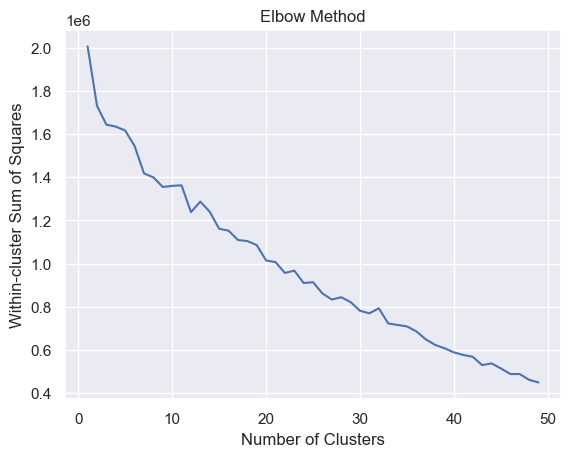

In [38]:
plt.plot(range(1, 50), sum_of_sq[1:50])
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-cluster Sum of Squares")

In [39]:
pd.DataFrame(sum_of_sq, columns=["Difference in SS"], index=range(1, 51)).diff()

,Difference in SS
1,NaN
2,-194016.583786
3,-275684.055494
4,-87001.108478
5,-8910.169404
6,-18262.178351
7,-71909.411370
8,-126727.799236
9,-18516.438868
10,-44552.553729


## Clustering


In [40]:
gmm = GaussianMixture(n_components=17)
gmm.fit(transposed.dropna().transpose())

GaussianMixture(n_components=17)

In [41]:
# Prediction for each company
clusters = gmm.predict(transposed.dropna().transpose())
clusters_df = pd.DataFrame({"Cluster": clusters, "Companies": transposed.columns})

# Sort by clusters
clusters_df = clusters_df.sort_values(["Cluster"]).reset_index(drop=True)

In [42]:
clusters_df.head()

,Cluster,Companies
0,0,DE
1,0,CAT
2,1,MRK
3,1,COST
4,1,PFE


In [43]:
clusters_df[clusters_df["Cluster"] == 10]

,Cluster,Companies
68,10,BA


## Training Data


In [44]:
all_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'symbol',
       'SMA_5', 'SMA_15', 'SMA_ratio', 'SMA_5_Volume', 'SMA_15_Volume',
       'SMA_Volume_Ratio', 'Lowest_5D', 'High_5D', 'Lowest_15D', 'High_15D',
       'Stochastic_5', 'Stochastic_15', 'Stochastic_%D_5', 'Stochastic_%D_15',
       'Stochastic_Ratio', 'Diff', 'Up', 'Down', 'avg_5Up', 'avg_5Down',
       'avg_15Up', 'avg_15Down', 'RS_5', 'RS_15', 'RSI_5', 'RSI_15',
       'RSI_Ratio', '12Ewm', '26Ewm', 'MACD', '20_MA', '20_SD',
       'bollinger_upper', 'bollinger_lower', 'RC', 'Close_Shifted', 'Target',
       'Target_Direction'],
      dtype='object')

In [45]:
all_data.index.min()

Timestamp('1990-02-09 00:00:00')

In [46]:
all_data.index = pd.to_datetime(all_data.index)
all_data.sort_index(inplace=True)

train_end = "2018-12-31"
train_start = "1990-10-15"
test_start = "2019-01-01"
test_end = "2020-11-16"

train_data = all_data.loc[train_start:train_end]
test_data = all_data.loc[test_start:test_end]

print(f"length of train data: {len(train_data)}")
print(f"length of test data: {len(test_data)}")

length of train data: 602570
length of test data: 47319


In [47]:
X_train = train_data.loc[:, target_vars]
y_train = train_data.loc[:, ["Target_Direction"]]

# Create validaton curve for RDC
rfc = RandomForestClassifier()
train_score_num, test_score_num = validation_curve(
    rfc,
    X=X_train["2010-01-01":],
    y=y_train.loc["2010-01-01":, "Target_Direction"],
    param_name="n_estimators",
    param_range=[3, 4, 7, 10, 12, 15, 20, 25, 30],
    cv=TimeSeriesSplit(n_splits=3),
)

In [48]:
train_score_mean = np.mean(train_score_num, axis=1)
train_score_std = np.std(train_score_num, axis=1)
test_score_mean = np.mean(test_score_num, axis=1)
test_score_std = np.std(test_score_num, axis=1)

Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

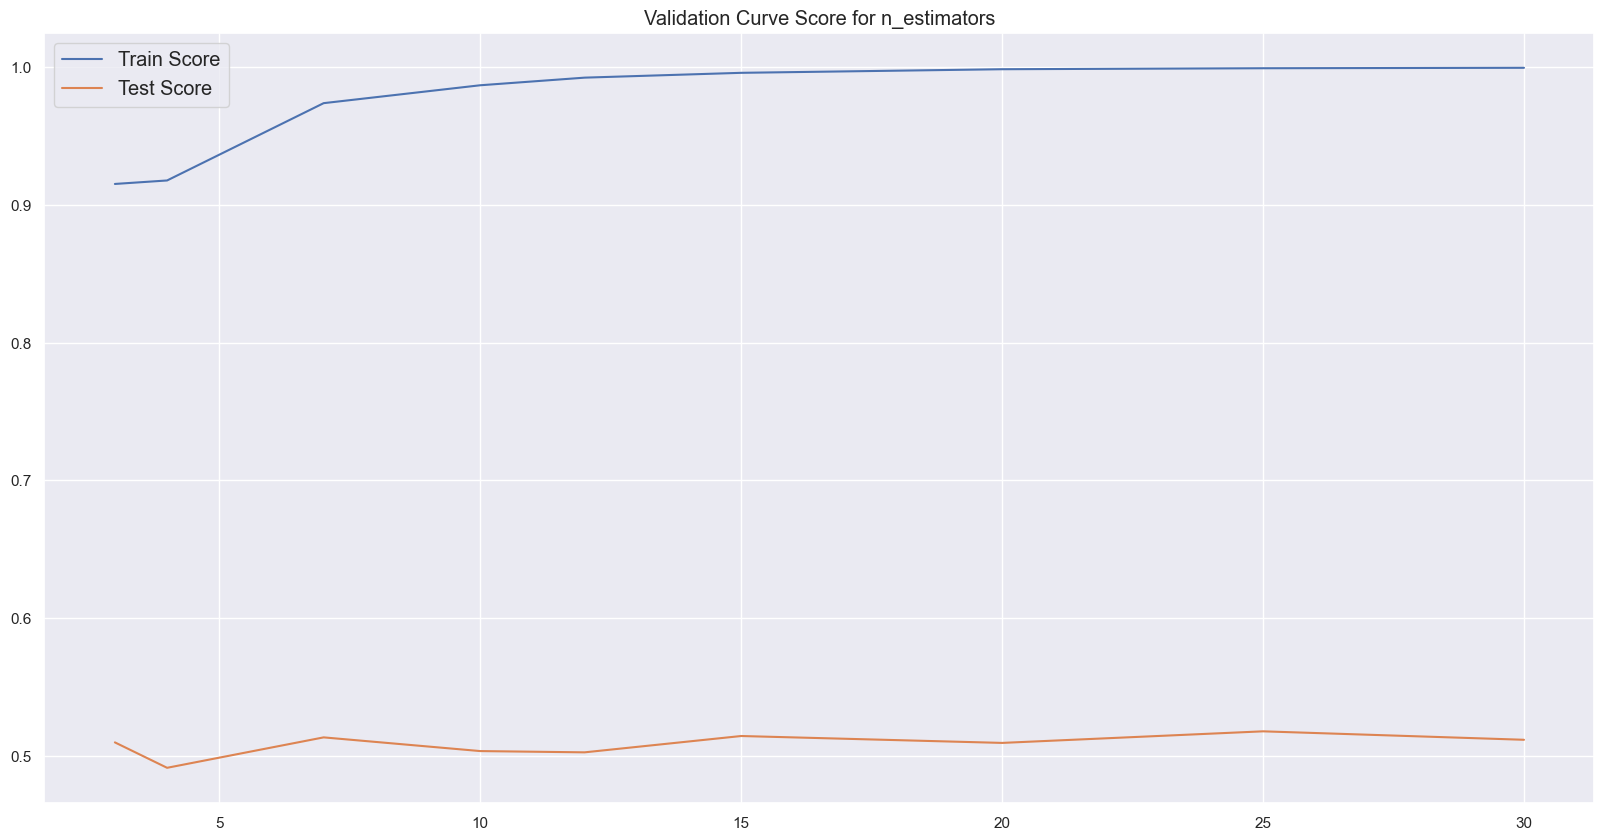

In [49]:
plt.figure(figsize=(20, 10))
plt.plot([3, 4, 7, 10, 12, 15, 20, 25, 30], train_score_mean)
plt.plot([3, 4, 7, 10, 12, 15, 20, 25, 30], test_score_mean)
plt.legend(["Train Score", "Test Score"], fontsize="large")
plt.title("Validation Curve Score for n_estimators", fontsize="large")

## Random Forest Model


In [50]:
# Iterate through each cluster
for cluster in clusters_df["Cluster"].unique():

    print(f"Current cluster: {cluster}")

    # Retrieve data for specific cluster

    cluster_companies = clusters_df.loc[
        clusters_df["Cluster"] == cluster, "Companies"
    ].tolist()
    cluster_data = all_data[all_data["symbol"].isin(cluster_companies)]
    cluster_train = cluster_data[:"2018-12-31"]
    cluster_train = cluster_train.dropna().copy()

    X_train = cluster_train.loc[:, target_vars]
    y_train = cluster_train.loc[:, ["Target_Direction"]]

    # Define params from validation curve
    params = {
        "max_depth": [5, 7],
        "max_features": ["sqrt"],
        "min_samples_leaf": [10, 15, 20],
        "n_estimators": [5, 7, 9],
        "min_samples_split": [20, 25, 30],  # Using validation curve
    }

    rfc = RandomForestClassifier()

    # Timeseries split
    time_series_split = TimeSeriesSplit(n_splits=3)

    rfc_cv = GridSearchCV(rfc, params, cv=time_series_split, n_jobs=-1, verbose=20)

    # Fit random forest
    rfc_cv.fit(X_train, y_train)

    # Save fitted variable into pickle file
    f_path = f"{os.getcwd()}/Pickle_Files/Cluster_{cluster}.pkl"
    pickle.dump(rfc_cv.best_estimator_, open(f_path, "wb"))

Current cluster: 0
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 2/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 2/54] START max_depth=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.527 total time=   0.1s
[CV 1/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.516 total time=   0.1s
[CV 2/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.511 total time=   0.1s
[CV 1/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.520 total time=   0.1s
[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.530 total time=   0.1s
[CV 1/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.0s
[CV 2/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.503 total time=   0.0s
[CV 2/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 15

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.490 total time=   0.1s
[CV 3/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.534 total time=   0.1s
[CV 2/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.506 total time=   0.1s
[CV 1/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.498

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.501 total time=   0.1s
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.518 total time=   0.1s
[CV 1/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 2/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.498 total time=   0.1s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.491 total time=   0.1s
[CV 2/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.509 total time=   0.0s
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.501 total time=   0.0s
[CV 2/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 3/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.523 total time=   0.1s
[CV 3/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.517 total time=   0.1s
[CV 1/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.512 total time=   0.0s
[CV 2/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.514 total time=   0.1s
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.501 total time=   0.1s
[CV 3/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.530 total time=   0.1s
[CV 3/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.522 total time=   0.1s
[CV 2/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.507 total time=   0.1s
[CV 3/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.516 total time=   0.1s

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 2/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 3/54] START max_depth=5, max_features=sqr

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.527 total time=   0.2s
[CV 3/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.522 total time=   0.2s
[CV 1/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.522 total time=   0.3s
[CV 1/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.524 total time=   0.3s
[CV 2/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 3/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.528 total time=   0.2s
[CV 1/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.526 total time=   0.4s
[CV 2/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.526 total time=   0.3s
[CV 3/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.532 total time=   0.5s
[CV 1/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.533 total time=   0.7s
[CV 3/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 1/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.523 total time=   0.2s
[CV 1/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.524 total time=   0.2s
[CV 2/3; 8/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 3/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.534 total time=   0.5s
[CV 1/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 3/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.532 total time=   1.0s
[CV 3/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 3/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.532 total time=   0.7s
[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.524 total time=   0.6s
[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.528 total time=   0.3s
[CV 2/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, 

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.531 total time=   0.2s
[CV 2/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.523 total time=   0.3s
[CV 3/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.521 total time=   0.5s
[CV 3/3; 8/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 1/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.523 total time=   0.2s
[CV 2/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.536 total time=   0.7s
[CV 1/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.530 total time=   0.1s
[CV 1/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.523 total time=   0.2s
[CV 2/3; 15/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.522 total time=   0.2s
[CV 2/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.535 total time=   0.5s
[CV 1/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.533 total time=   0.3s
[CV 2/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.524 total time=   0.5s
[CV 3/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 1/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.531 total time=   0.2s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.524 total time=   0.1s
[CV 2/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 3/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 2/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.523 total time=   0.5s
[CV 2/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.523 total time=   0.6s
[CV 3/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.532 total time=   0.5s
[CV 1/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.530 total time=   0.9s
[CV 2/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 2/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.521 total time=   0.6s
[CV 3/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.528 total time=   0.1s
[CV 3/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.526 total time=   0.3s
[CV 2/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.535 total time=   0.7s
[CV 2/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.524 total time=   0.2s
[CV 2/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.531 total time=   0.3s
[CV 1/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.528 total time=   0.2s
[CV 3/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.527 total time=   0.1s
[CV 2/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.525 total time=   0.4s
[CV 2/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 2/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.525 total time=   0.5s
[CV 3/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.525 total time=   0.5s
[CV 1/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 3/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.532 total time=   0.5s
[CV 3/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.528 total time=   0.1s
[CV 3/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.537 total time=   0.7s
[CV 3/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.529 total time=   0.5s
[CV 1/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 3/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.527 total time=   0.2s
[CV 2/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.521 total time=   0.4s
[CV 3/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.520 total time=   0.2s
[CV 2/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.525 total time=   0.6s
[CV 2/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 3/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.533 total time=   0.8s
[CV 1/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.533 total time=   0.9s
[CV 1/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.520 total time=   0.8s
[CV 3/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 3/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.531 total time=   1.0s
[CV 1/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.528 total time=   0.8s
[CV 1/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.524 total time=   0.4s
[CV 2/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.520 total time=   0.3s
[CV 2/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 1/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.524 total time=   0.4s
[CV 1/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.522 total time=   0.6s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.522 total time=   0.4s
[CV 3/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.521 total time=   0.2s
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.521 total time=   0.5s
[CV 2/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.520 total time=   0.7s
[CV 2/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.524 total time=   0.7s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.527 total time=   0.9s
[CV 1/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.526 total time=   0.6s
[CV 1/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 3/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.530 total time=   1.2s
[CV 3/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.534 total time=   1.2s
[CV 1/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 1/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.523 total time=   0.3s
[CV 2/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.524 total time=   0.2s
[CV 2/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 1/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.523 total time=   0.3s
[CV 2/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.522 total time=   0.6s
[CV 3/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 1/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.524

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.527 total time=   0.2s
[CV 2/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.520 total time=   0.6s
[CV 2/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.520 total time=   0.4s
[CV 2/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.521 total time=   0.8s
[CV 2/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.526 total time=   1.1s
[CV 3/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=3

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.521 total time=   0.2s
[CV 1/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.522 total time=   0.3s
[CV 2/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.533 total time=   0.9s
[CV 1/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.520 total time=   0.2s
[CV 1/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.521 total time=   0.5s
[CV 3/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.522 total time=   0.4s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.520 total time=   0.2s
[CV 2/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.519 total time=   0.6s
[CV 3/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 2/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.520 total time=   0.7s
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.522 total time=   0.8s
[CV 1/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.532 total time=   0.7s
[CV 3/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=3

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.528 total time=   0.9s
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.529 total time=   1.1s
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.523 total time=   0.4s
[CV 1/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.521 total time=   0.2s
[CV 3/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.528 total time=   0.9s
[CV 3/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.524 total time=   0.2s
[CV 1/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.521 total time=   0.4s
[CV 2/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.534 total time=   1.1s
[CV 3/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.521 total time=   0.7s
[CV 2/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.521 total time=   0.5s
[CV 1/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.521 total time=   0.4s
[CV 3/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 1/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.527 total time=   0.3s
[CV 2/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current cluster: 2
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 2/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 1/54] END max_depth=5,

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.510 total time=   0.1s
[CV 2/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 3/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.517 total time=   0.2s
[CV 1/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.510 total time=   0.1s
[CV 1/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.513 total time=   0.2s
[CV 2/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 1/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.513 total time=   0.1s
[CV 1/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 2/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.521 total time=   0.4s
[CV 2/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.512 total time=   0.4s
[CV 3/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.525 total time=   0.3s
[CV 1/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_est

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.516 total time=   0.5s
[CV 1/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.521 total time=   0.2s
[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.513 total time=   0.2s
[CV 2/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 3/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.518 total time=   0.4s
[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.522 total time=   0.6s
[CV 1/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.2s
[CV 3/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 2/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.522 total time=   0.4s
[CV 2/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.525 total time=   0.2s
[CV 3/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.519 total time=   0.6s
[CV 1/3; 10/54] START max_depth=5, max_features=sqrt, min_samples

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.511 total time=   0.1s
[CV 1/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.514 total time=   0.5s
[CV 2/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.514 total time=   0.4s
[CV 1/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.510 

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.508 total time=   0.2s
[CV 2/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 2/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.524 total time=   0.3s
[CV 3/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.511 total time=   0.1s
[CV 2/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 1/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.509 total time=   0.2s
[CV 3/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.518 total time=   0.4s
[CV 3/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.518 total time=   0.3s
[CV 3/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.521 total time=   0.7s
[CV 2/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 1/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.519 total time=   0.5s
[CV 1/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.515 total time=   0.1s
[CV 3/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.518 total time=   0.5s
[CV 3/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.519 total time=   0.3s
[CV 1/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.510 total time=   0.1s
[CV 2/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.522 total time=   0.3s
[CV 3/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.521 total time=   0.6s
[CV 2/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.526 total time=   0.2s
[CV 3/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.517 total time=   0.3s
[CV 3/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.519 total time=   0.5s
[CV 1/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.511 total time=   0.1s
[CV 2/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.506 total time=   0.2s
[CV 1/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.507 total time=   0.2s
[CV 2/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.510 total time=   0.1s
[CV 2/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.516 total time=   0.3s
[CV 2/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 3/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.516 total time=   0.6s
[CV 1/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.519 total time=   0.5s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.515 total time=   0.4s
[CV 1/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.519 total time=   0.2s
[CV 3/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.517 total time=   0.4s
[CV 2/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.521 total time=   0.4s
[CV 1/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.516 total time=   0.4s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.511 total time=   0.2s
[CV 2/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 1/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.509 total time=   0.2s
[CV 2/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 1/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.513 total time=   0.2s
[CV 2/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=3

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.517 total time=   0.2s
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.519 total time=   0.6s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.6s
[CV 1/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.4s
[CV 2/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.520 total time=   0.3s
[CV 3/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.515 total time=   0.8s
[CV 1/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.516 total time=   0.5s
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.519 total time=   0.5s
[CV 3/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.521 total time=   0.4s
[CV 1/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_sam

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.514 total time=   0.2s
[CV 2/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.508 total time=   0.2s
[CV 2/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.522 total time=   0.4s
[CV 3/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 1/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.510

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.520 total time=   0.4s
[CV 3/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 2/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.515 total time=   0.3s
[CV 3/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.517 total time=   0.4s
[CV 1/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 2/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.515 total time=   0.8s
[CV 1/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.508 total time=   0.2s
[CV 3/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.518 total time=   0.5s
[CV 3/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 1/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.508 total time=   0.1s
[CV 2/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 1/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.513 total time=   0.2s
[CV 2/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 1/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.509 total time=   0.2s
[CV 2/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.518 total time=   0.7s
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.515 total time=   0.4s
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.512 total time=   0.3s
[CV 2/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.520 total time=   0.5s
[CV 3/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=3

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.512 total time=   0.1s
[CV 3/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.6s
[CV 1/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.512 total time=   0.2s
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 2/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 1/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.513 total time=   0.2s
[CV 3/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.518 total time=   0.4s
[CV 2/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.521 total time=   0.5s
[CV 2/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.520 total time=   0.5s
[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.522 total time=   0.7s
[CV 3/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.518 total time=   0.4s
[CV 3/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.512 total time=   0.7s
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 53/54] END max_depth=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.511 total time=   0.2s
[CV 3/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.510 total time=   0.7s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current cluster: 3
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.538 total time=   0.0s
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.548 total time=   0.0s
[CV 2/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.526 total time=   0.0s
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.505 total time=   0.0s
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.509 total time=   0.0s
[CV 3/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

Current cluster: 4
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 2/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 3/54] START max_depth=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.527 total time=   0.2s
[CV 2/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.529 total time=   0.2s
[CV 3/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.526 total time=   0.3s
[CV 1/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.527 total time=   0.3s
[CV 2/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.553 total time=   0.4s
[CV 3/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.528 total time=   0.3s
[CV 1/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.550 total time=   0.6s
[CV 2/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.548 total time=   0.5s
[CV 3/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.555 total time=   0.7s
[CV 1/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 2/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.550 total time=   0.8s
[CV 2/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.550 total time=   1.1s
[CV 2/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.527 total time=   0.3s
[CV 3/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.550 total time=   0.4s
[CV 1/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.556 total time=   0.9s
[CV 2/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.527 total time=   0.4s
[CV 3/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.552 total time=   0.8s
[CV 1/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 1/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.526 total time=   0.2s
[CV 2/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 3/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.555 total time=   0.7s
[CV 3/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.527 total time=   0.3s
[CV 2/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 2/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.547 total time=   0.4s
[CV 3/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.552 total time=   1.1s
[CV 1/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.551 total time=   0.7s
[CV 3/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.554 total time=   0.9s
[CV 2/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 3/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 1/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.526 total time=   0.3s
[CV 1/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.527 total time=   0.2s
[CV 2/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.528 total time=   0.3s
[CV 2/3; 15/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 2/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.549 total time=   0.4s
[CV 3/3; 15/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 1/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.529 total time=   0.3s
[CV 2/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.551 total time=   0.7s
[CV 2/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.552 total time=   1.2s
[CV 1/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.551 total time=   0.6s
[CV 2/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 2/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.548 total time=   0.6s
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.527 total time=   0.2s
[CV 1/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.528 total time=   0.3s
[CV 2/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.549 total time=   0.5s
[CV 3/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.551 total time=   1.2s
[CV 1/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 1/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.529 total time=   0.4s
[CV 3/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.546 total time=   0.8s
[CV 1/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.548 total time=   0.7s
[CV 2/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 1/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.528 total time=   0.2s
[CV 3/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 2/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.551 total time=   0.6s
[CV 1/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.528 total time=   0.3s
[CV 2/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.551 total time=   0.4s
[CV 3/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.552 total time=   1.1s
[CV 1/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 3/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.558 total time=   0.9s
[CV 2/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.552 total time=   0.7s
[CV 1/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.528 total time=   0.3s
[CV 3/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.533 total time=   0.2s
[CV 2/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.553 total time=   0.7s
[CV 3/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.527 total time=   0.3s
[CV 2/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.545 total time=   0.4s
[CV 3/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.550 total time=   1.2s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.528 total time=   0.4s
[CV 3/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.558 total time=   0.9s
[CV 1/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 2/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 2/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.550 total time=   0.7s
[CV 1/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 2/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.548

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 1/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.528 total time=   0.3s
[CV 2/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.546 total time=   0.5s
[CV 3/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 3/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.552 total time=   1.2s
[CV 3/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.552 total time=   0.9s
[CV 1/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.530 total time=   0.3s
[CV 1/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.526 total time=   0.4s
[CV 2/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.553 total time=   1.2s
[CV 2/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.545 total time=   0.5s
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.553 total time=   0.7s
[CV 3/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.525 total time=   0.5s
[CV 1/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.527 total time=   0.2s
[CV 2/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 3/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.540 total time=   0.8s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.541 total time=   0.8s
[CV 1/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.549 total time=   1.2s
[CV 2/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 1/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.525 total time=   0.4s
[CV 3/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.541 total time=   0.6s
[CV 1/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.543 total time=   1.2s
[CV 1/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.530 total time=   0.5s
[CV 2/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.546 total time=   0.9s
[CV 1/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 2/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.548 total time=   1.0s
[CV 2/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.524 total time=   0.4s
[CV 2/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.543 total time=   0.7s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.542 total time=   1.3s
[CV 1/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.526 total time=   0.5s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.546 total time=   1.0s
[CV 3/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.547

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.523 total time=   0.3s
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.529 total time=   0.4s
[CV 2/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.541 total time=   0.6s
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.547 total time=   1.2s
[CV 3/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.545 total time=   1.6s
[CV 3/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 2/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.526 total time=   0.5s
[CV 3/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.530 total time=   0.3s
[CV 2/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.548 total time=   0.8s
[CV 3/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 3/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.546 total time=   0.9s
[CV 1/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.527 total time=   0.4s
[CV 2/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 2/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.540 total time=   0.6s
[CV 3/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.546 total time=   1.2s
[CV 1/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.525 total time=   0.5s
[CV 1/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 2/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.547 total time=   1.0s
[CV 2/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 3/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 3/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.548 total time=   1.5s
[CV 1/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.540 total time=   0.9s
[CV 2/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.525 total time=   0.3s
[CV 2/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.550 total time=   0.8s
[CV 3/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.526 total time=   0.4s
[CV 2/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.544 total time=   0.6s
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.546 total time=   0.9s
[CV 1/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 3/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.549 total time=   1.2s
[CV 2/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.546 total time=   1.6s
[CV 1/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.524 total time=   0.5s
[CV 3/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 1/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.546 total time=   0.9s
[CV 2/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 1/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.524 total time=   0.3s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 2/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.547 total time=   0.9s
[CV 1/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.525 total time=   0.5s
[CV 2/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.542 total time=   0.7s
[CV 3/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.545 total time=   1.7s
[CV 1/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 3/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.544 total time=   1.2s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.525 total time=   0.4s
[CV 3/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.547 total time=   1.0s
[CV 1/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.540 total time=   0.8s
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.542 total time=   0.8s
[CV 1/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.525 total time=   0.3s
[CV 3/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.530 total time=   0.4s
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.543 total time=   0.6s
[CV 3/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.549 total time=   1.2s
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.527 total time=   0.5s
[CV 2/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.545 total time=   1.6s
[CV 3/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 2/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.547 total time=   1.0s
[CV 1/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.547 total time=   0.9s
[CV 3/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.526 total time=   0.3s
[CV 1/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.530 total time=   0.4s
[CV 2/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.542 total time=   0.5s
[CV 3/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.525 total time=   0.4s
[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.548 total time=   1.6s
[CV 3/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.544 total time=   1.2s
[CV 2/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.548 total time=   1.0s
[CV 3/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.541 total time=   0.8s
[CV 2/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.543 total time=   0.7s
[CV 3/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.546 total time=   1.3s

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current cluster: 5
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.542 total time=   0.0s
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.483 total time=   0.0s
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_sa

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.506 total time=   0.0s
[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.506 total time=   0.0s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.544 total time=   0.0s
[CV 1/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 3/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.538 total time=   0.0s
[CV 3/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.531 total time=   0.0s
[CV 2/3; 3/54] STAR

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.509 total time=   0.1s
[CV 3/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.509 total time=   0.2s
[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.515 total time=   0.1s
[CV 3/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.527 total time=   0.1s
[CV 2/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, 

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 1/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.527 total time=   0.1s
[CV 1/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 2/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.515 total time=   0.1s
[CV 3/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 3/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.515 total time=   0.1s
[CV 1/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.522

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.529 total time=   0.0s
[CV 2/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.506 total time=   0.2s
[CV 1/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 2/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.513 total time=   0.1s
[CV 3/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.514 total time=   0.2s
[CV 2/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 2/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.520 total time=   0.1s
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.508 total time=   0.2s
[CV 1/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.527 total time=   0.1s
[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.527 total time=   0.1s
[CV 3/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.514 total time=   0.1s
[CV 3/3; 37/54] END max_depth=7, max_features=sqrt, min_sampl

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.522 total time=   0.1s
[CV 1/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9[CV 2/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7

[CV 2/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.515 total time=   0.1s
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.526 total time=   0.1s
[CV 3/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.523 total time=   0.1s
[CV 1/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.529 total time=   0.1s
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.527 total time=   0.2s
[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.521 total time=   0.2s
[CV 3/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.518 total time=   0.2s
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.529 total time=   0.2s
[CV 3/3; 48/54] START max_depth=7, max_features=sqrt, min_sam

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.527 total time=   0.1s
[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.514 total time=   0.2s
[CV 3/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.509 total time=   0.1s
[CV 2/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.515 total time=   0.1s
[CV 3/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.514 total time=   0.2s
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.511 total time=   0.2s
[CV 1/3; 54/54] START max_dept

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current cluster: 7
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 2/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 3/54] START max_depth=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.522 total time=   0.2s
[CV 3/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.503 total time=   0.2s
[CV 1/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 1/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.517 total time=   0.1s
[CV 3/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.521 total time=   0.2s
[CV 1/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.500 total time=   0.4s
[CV 1/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.518 total time=   0.1s
[CV 3/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.523 total time=   0.2s
[CV 2/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.518 tot

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.515 total time=   0.1s
[CV 2/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 1/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.1s
[CV 3/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 3/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.506 total time=   0.4s
[CV 2/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.523 total time=   0.3s
[CV 3/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.496 total time=   0.2s
[CV 1/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.501 total time=   0.3s
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.519 total time=   0.1s
[CV 2/3; 15/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 2/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.520 total time=   0.2s
[CV 3/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.498 total time=   0.3s
[CV 2/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 2/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.518 total time=   0.2s
[CV 2/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.517 total time=   0.1s
[CV 1/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.501 total time=   0.4s
[CV 1/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 2/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=3

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.520 total time=   0.1s
[CV 3/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.520 total time=   0.1s
[CV 3/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.515 total time=   0.1s
[CV 2/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.526 total time=   0.3s
[CV 3/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.519 total time=   0.2s
[CV 2/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.518 total time=   0.2s
[CV 2/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 3/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.505 total time=   0.3s
[CV 1/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.510 total time=   0.1s
[CV 2/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.511 total time=   0.1s
[CV 2/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.525 total time=   0.2s
[CV 3/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.518 total time=   0.2s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 3/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.498 total time=   0.3s
[CV 1/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 3/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.501 total time=   0.4s
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.516 total time=   0.3s
[CV 1/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.503 total time=   0.4s
[CV 1/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.508 total time=   0.1s
[CV 2/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.514 total time=   0.1s
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 1/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.518 total time=   0.2s
[CV 3/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.517 total time=   0.3s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.516 total time=   0.3s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.501 total time=   0.5s
[CV 1/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.517 total time=   0.3s
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.518 total time=   0.4s
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.502 total time=   0.6s
[CV 1/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.515 total time=   0.1s
[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.516 total time=   0.1s
[CV 2/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 1/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.516 total time=   0.1s
[CV 2/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.518 total time=   0.3s
[CV 3/3; 38/54] START max_depth=7, max_features=sqrt, min_sam

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.517 total time=   0.2s
[CV 2/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.504 total time=   0.6s
[CV 1/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.525 total time=   0.3s
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.502 total time=   0.3s
[CV 1/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.517 total time=   0.1s
[CV 2/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 2/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.514 total time=   0.2s
[CV 3/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 2/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.518 total time=   0.3s
[CV 3/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.515

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.517 total time=   0.2s
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.518 total time=   0.2s
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.514 total time=   0.4s
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.504 total time=   0.4s
[CV 1/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.517 total time=   0.1s
[CV 3/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.516 total time=   0.1s
[CV 2/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 1/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.513 total time=   0.1s
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 1/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.511

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.514 total time=   0.3s
[CV 2/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.516 total time=   0.3s
[CV 2/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.516 total time=   0.2s
[CV 3/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.500 total time=   0.3s
[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.506 total time=   0.5s
[CV 3/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.499 total time=   0.5s
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 53/54] END max_depth=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current cluster: 8
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.500 total time=   0.0s
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, 

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.502 total time=   0.0s
[CV 3/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.502 total time=   0.0s
[CV 1/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.510 total time=   0.0s
[CV 2/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.502 total time=   0.0s
[CV 3/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.499 total time=   0.0s
[CV 2/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.499 total time=   0.0s
[CV 2/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 2/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.522 total time=   0.0s
[CV 3/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 1/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.508 total time=   0.0s
[CV 2/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 3/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.478 total time=   0.0s
[CV 3/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.490 total time=   0.0s
[CV 2/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.501 total time=   0.0s
[CV 3/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.488 total time=   0.1s
[CV 1/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.516 total time=   0.0s
[CV 3/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 1/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.523 total time=   0.0s
[CV 1/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.505 total time=   0.0s
[CV 3/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.523 total t

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.492 total time=   0.0s
[CV 2/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.505 total time=   0.0s
[CV 1/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.511 total time=   0.0s
[CV 2/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.500 total time=   0.0s
[CV 3/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 3/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.524 total time=   0.0s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.510 total time=   0.0s
[CV 2/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 1/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.518 total time=   0.0s
[CV 2/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 1/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.508 total time=   0.0s
[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.516 total time=   0.0s
[CV 3/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.505 total time=   0.0s
[CV 3/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.490 total time=   0.1s
[CV 3/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.502 total time=   0.1s
Current cluster: 10
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.503 total time=   0.0s
[CV 2/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.509 total time=   0.0s
[CV 1/3; 8/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 1/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 2/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.501 total time=   0.0s
[CV 3/3; 8/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 1/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.511 total

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.501 total time=   0.0s
[CV 2/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.510 total time=   0.0s
[CV 1/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.515 total time=   0.0s
[CV 2/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.490 total time=   0.0s
[CV 3/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.496 total time=   0.0s
[CV 1/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.506 total time=   0.0s
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.488 total time=   0.1s
[CV 1/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.495 total time=   0.0s
[CV 1/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

Current cluster: 11
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.510 total time=   0.0s
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.544 total time=   0.0s
[CV 1/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.520 total time=   0.0s
[CV 1/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.508 total time=   0.0s
[CV 2/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.526 total time=   0.0s
[CV 1/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.507 total time=   0.0s
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.476 total time=   0.0s
[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.510 total time=   0.0s
[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.504 total time=   0.0s
[CV 3/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.533 total time=   0.0s
[CV 2/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.528 total time=   0.0s
[CV 3/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 3/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.505 total time=   0.0s
[CV 1/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.545 total time=   0.0s
[CV 2/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.522 total time=   0.0s
[CV 3/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.526 total time=   0.0s
[CV 3/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 3/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.510 total time=   0.0s
[CV 3/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.491 total time=   0.0s
[CV 1/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.525 total time=   0.0s
[CV 2/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.522 total time=   0.0s
[CV 2/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.495 total time=   0.0s
[CV 2/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.519 total time=   0.0s
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.500 total time=   0.1s
Current cluster: 13
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.487 total time=   0.0s
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 2/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.496 total time=   0.0s
[CV 3/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 1/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.462 total time=   0.0s
[CV 2/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.533 total time=   0.0s
[CV 3/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.562 total time=   0.0s
[CV 1/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 2/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 3/54] START max_depth=5, max_features=sqr

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.525 total time=   0.3s
[CV 2/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.526 total time=   0.3s
[CV 3/3; 4/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.524 total time=   0.4s
[CV 1/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.527 total time=   0.4s
[CV 1/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 5/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.523 total time=   0.3s
[CV 1/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.543 total time=   0.8s
[CV 2/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.551 total time=   0.9s
[CV 3/3; 6/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.545 total time=   0.5s
[CV 1/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.547 total time=   1.0s
[CV 2/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 1/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.524 total time=   0.3s
[CV 3/3; 7/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 3/3; 4/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.548 total time=   0.8s
[CV 1/3; 8/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 3/3; 2/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.551 total time=   1.2s
[CV 2/3; 8/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_e

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.546 total time=   0.9s
[CV 1/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 1/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.526 total time=   0.3s


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 3/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.552 total time=   1.5s
[CV 3/3; 9/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.544 total time=   0.5s
[CV 1/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 5/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.551 total time=   1.2s
[CV 2/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.549 total time=   1.0s
[CV 3/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 1/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.522 total time=   0.5s
[CV 1/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 1/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.523 total time=   0.3s
[CV 2/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.548 total time=   0.8s
[CV 3/3; 11/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 3/3; 7/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.552 total time=   0.9s
[CV 1/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 2/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.548 total time=   0.5s
[CV 2/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.524 total time=   0.3s
[CV 3/3; 12/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 8/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.551 total time=   1.2s
[CV 3/3; 6/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.551 total time=   1.5s
[CV 1/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 2/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.548 total time=   0.9s
[CV 3/3; 13/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 1/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.527 total time=   0.4s
[CV 1/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.546 total time=   0.7s
[CV 2/3; 14/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 3/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.552 

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.523 total time=   0.4s
[CV 2/3; 15/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 2/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.545 total time=   0.6s
[CV 3/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.550 total time=   1.4s
[CV 3/3; 15/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 1/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 2/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.549 total time=   0.9s
[CV 2/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 11/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.550 total time=   1.2s
[CV 1/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.524 total time=   0.4s
[CV 3/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.522 total time=   0.2s
[CV 2/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.547 total time=   0.9s
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.526 total time=   0.3s
[CV 2/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.551 total time=   1.4s
[CV 3/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.544 total time=   0.5s
[CV 1/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 1/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.524 total time=   0.4s
[CV 2/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.554 total time=   1.1s
[CV 3/3; 19/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 2/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.546 total time=   0.9s
[CV 1/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.524 total time=   0.3s
[CV 1/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 2/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.550 total time=   0.8s
[CV 3/3; 20/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.522 total time=   0.3s
[CV 2/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.547 total time=   0.5s
[CV 3/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.552 total time=   1.0s
[CV 1/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.524 total time=   0.4s
[CV 3/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.523 total time=   0.2s
[CV 2/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.544 total time=   0.7s
[CV 3/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 19/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.553 total time=   0.8s
[CV 1/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.521 total time=   0.4s
[CV 2/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.544 total time=   0.5s
[CV 3/3; 24/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 3/3; 18/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.550 total time=   1.4s
[CV 1/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 20/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.551 total time=   1.1s
[CV 2/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 2/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.547 total time=   0.9s
[CV 3/3; 22/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.553 total time=   0.8s
[CV 2/3; 23/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.547 total time=   0.7s
[CV 3/3; 25/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 2/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.524 total time=   0.3s
[CV 3/3; 26/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 1/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.523 total time=   0.6s
[CV 1/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 1/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.525 total time=   0.3s
[CV 2/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.547 total time=   0.5s
[CV 3/3; 27/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 21/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.550 total time=   1.4s
[CV 3/3; 28/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.545 total time=   0.9s
[CV 1/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.548 total time=   0.8s
[CV 2/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.516 total time=   0.4s
[CV 3/3; 29/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 3/3; 25/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.551 total time=   0.9s
[CV 1/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.522 total time=   0.5s
[CV 2/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 3/3; 26/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.551 total time=   1.1s
[CV 3/3; 30/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.549 total time=   0.8s
[CV 1/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 2/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.540 total time=   0.7s
[CV 2/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 24/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.552 total time=   1.5s
[CV 3/3; 31/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5
[CV 1/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.523 total time=   0.5s
[CV 1/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 1/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.520 total time=   0.3s
[CV 2/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 28/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.547 total time=   1.2s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 29/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7;, score=0.543 total time=   0.9s
[CV 1/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 3/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.553 total time=   1.4s
[CV 2/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9
[CV 2/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.537 total time=   0.6s
[CV 3/3; 33/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.521 total time=   0.3s
[CV 2/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 2/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.539 total time=   1.2s
[CV 3/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 1/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.518 total time=   0.5s
[CV 1/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7
[CV 3/3; 31/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=5;, score=0.544 total time=   1.0s
[CV 2/3; 35/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.522 total time=   0.4s
[CV 2/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 2/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.542 total time=   0.7s
[CV 3/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.520 total time=   0.7s
[CV 1/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 2/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.545 total time=   1.4s
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.547 total time=   1.5s
[CV 3/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9;, score=0.547 total time=   2.2s
[CV 1/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.542 total time=   1.0s
[CV 2/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7
[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.520 total time=   0.4s
[CV 3/3; 38/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.546 total time=   1.2s
[CV 1/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.522 total time=   0.4s
[CV 2/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 33/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=9;, score=0.548 total time=   2.0s
[CV 3/3; 39/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9
[CV 3/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.547 total time=   1.6s
[CV 2/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.541 total time=   0.7s
[CV 1/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 2/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.525 total time=   0.6s
[CV 3/3; 40/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5
[CV 2/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.542 total time=   1.4s
[CV 1/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 1/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.522 total time=   0.3s
[CV 2/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 2/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.539 total time=   1.0s
[CV 3/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.546 total time=   1.1s
[CV 1/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.539 total time=   0.7s
[CV 1/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.520 total time=   0.5s
[CV 2/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 3/3; 42/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9
[CV 3/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.550 total time=   1.9s
[CV 1/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 38/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=7;, score=0.545 total time=   1.5s
[CV 2/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.527 total time=   0.7s
[CV 3/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 2/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.541 total time=   1.3s
[CV 1/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.522 total time=   0.3s
[CV 2/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 3/3; 40/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.545 total time=   1.1s
[CV 1/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.521 total time=   0.5s
[CV 2/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.540 total time=   0.7s
[CV 3/3; 45/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 3/3; 39/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.548 total time=   1.9s
[CV 1/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.546 total time=   1.5s
[CV 2/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 1/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.518 total time=   0.6s
[CV 3/3; 46/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5
[CV 2/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.543 total time=   1.2s
[CV 1/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.519 total time=   0.3s
[CV 2/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 2/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.542 total time=   0.9s
[CV 3/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.548 total time=   1.1s
[CV 1/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.520 total time=   0.4s
[CV 2/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 2/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.539 total time=   0.7s
[CV 3/3; 48/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.549 total time=   1.8s
[CV 1/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.547 total time=   1.5s
[CV 1/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.519 total time=   0.6s
[CV 3/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 2/3; 49/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 1/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.518 total time=   0.3s
[CV 1/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.543 total time=   1.3s
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 46/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=5;, score=0.545 total time=   1.1s
[CV 3/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 2/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.541 total time=   1.0s
[CV 1/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.520 total time=   0.5s
[CV 2/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 2/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.538 total time=   0.7s
[CV 3/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.547 total time=   1.4s
[CV 3/3; 51/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9
[CV 1/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.544 total time=   1.2s
[CV 2/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.525 total time=   0.6s
[CV 3/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 45/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9;, score=0.547 total time=   2.0s
[CV 1/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.520 total time=   0.3s
[CV 3/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.548 total time=   1.1s
[CV 2/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 3/3; 53/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7
[CV 2/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.541 total time=   1.1s
[CV 1/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.525 total time=   0.5s
[CV 2/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9
[CV 2/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.546 total time=   0.7s
[CV 3/3; 54/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9


/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.546 total time=   2.0s
[CV 2/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.543 total time=   1.2s
[CV 3/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.548 total time=   1.6s
[CV 1/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.519 total time=   0.5s
[CV 3/3; 52/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5;, score=0.545 total time=   1.0s
[CV 2/3; 53/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=7;, score=0.539 total time=   0.9s
[CV 2/3; 54/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.539 total time=   1.0s

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Current cluster: 15
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.523 total time=   0.0s
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.502 total time=   0.0s
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_s

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 16/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 1/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 3/3; 9/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.510 total time=   0.1s
[CV 1/3; 10/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 3/3; 17/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 1/3; 12/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=9;, score=0.516 total time=   0.0s
[CV 1/3; 10/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.519 total time=   0.0s
[CV 3/3; 13/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=5;, score=0.513 

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 34/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5;, score=0.516 total time=   0.0s
[CV 3/3; 34/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=5
[CV 2/3; 32/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7;, score=0.505 total time=   0.0s
[CV 3/3; 32/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, n_estimators=7
[CV 2/3; 27/54] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=9;, score=0.505 total time=   0.0s
[CV 1/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.515 total time=   0.0s
[CV 2/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5
[CV 1/3; 30/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=2

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 2/3; 44/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.507 total time=   0.0s
[CV 3/3; 44/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7
[CV 2/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 42/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.540 total time=   0.0s
[CV 1/3; 47/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7;, score=0.510 total time=   0.0s
[CV 2/3; 47/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=7
[CV 3/3; 50/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 1/3; 43/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.500

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

Current cluster: 16
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 2/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 3/3; 1/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5
[CV 1/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 2/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 1/54] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=5;, score=0.517 total time=   0.0s
[CV 3/3; 2/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=7
[CV 1/3; 3/54] START max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=9

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 21/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9
[CV 3/3; 16/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5;, score=0.499 total time=   0.0s
[CV 3/3; 17/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=7;, score=0.497 total time=   0.0s
[CV 1/3; 18/54] START max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=9
[CV 2/3; 22/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5
[CV 2/3; 15/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=9;, score=0.498 total time=   0.0s
[CV 3/3; 23/54] START max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7
[CV 3/3; 14/54] END max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.505

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 41/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7;, score=0.479 total time=   0.0s
[CV 2/3; 41/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=25, n_estimators=7
[CV 3/3; 43/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=5
[CV 2/3; 35/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=7;, score=0.500 total time=   0.0s
[CV 1/3; 36/54] END max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9;, score=0.492 total time=   0.0s
[CV 2/3; 37/54] END max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split=20, n_estimators=5;, score=0.500 total time=   0.0s
[CV 2/3; 36/54] START max_depth=7, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=9
[CV 3/3; 37/54] START max_depth=7, max_features=sqrt, min_samples_leaf=15, min_samples_split

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1

[CV 1/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.501 total time=   0.0s
[CV 2/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 1/3; 51/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=9;, score=0.487 total time=   0.0s
[CV 3/3; 49/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=5;, score=0.496 total time=   0.0s
[CV 3/3; 52/54] START max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=5
[CV 3/3; 48/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=9;, score=0.497 total time=   0.1s
[CV 2/3; 50/54] END max_depth=7, max_features=sqrt, min_samples_leaf=20, min_samples_split=25, n_estimators=7;, score=0.513 total time=   0.0s
[CV 1/3; 53/54] START max_depth=7, max_features=sqrt, min_sam

/Users/weiming/Dev/Projects/ml-ta-forecast/envs/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [51]:
# Testing .loc
clusters_df.loc[clusters_df["Cluster"] == 1, "Companies"].tolist()

['MRK',
 'COST',
 'PFE',
 'PG',
 'BMY',
 'JNJ',
 'TGT',
 'CL',
 'WMT',
 'AMGN',
 'ABT',
 'VZ',
 'GILD',
 'TMO']

## Backtesting


In [52]:
# use 2nd Jan Data

day_data = test_data.loc["2019-01-02"]

pred_for_tomorrow = pd.DataFrame({"Date": [], "company": [], "prediction": []})

# Predict each stock using 2nd Jan data
for cluster in clusters_df["Cluster"].unique():
    rfc_cv = pickle.load(
        open(f"{os.getcwd()}/Pickle_Files/Cluster_{cluster}.pkl", "rb")
    )
    # best_rf = rfc.best_estimator_
    cluster_data = day_data.loc[
        day_data["symbol"].isin(
            clusters_df.loc[clusters_df["Cluster"] == cluster, "Companies"].tolist()
        )
    ].copy()
    cluster_data = cluster_data.dropna()

    if cluster_data.shape[0] > 0:
        X_test = cluster_data.loc[:, target_vars]

        pred_for_tomorrow = pd.concat(
            [
                pred_for_tomorrow,
                pd.DataFrame(
                    {
                        "Date": cluster_data.index,
                        "company": cluster_data["symbol"],
                        "prediction": rfc_cv.predict_proba(X_test)[:, 1],
                    }
                ),
            ],
            ignore_index=True,
        )

/var/folders/5_/5031yk8j46l_7pk431n48pyw0000gn/T/ipykernel_14717/3931134736.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_for_tomorrow = pd.concat(


In [53]:
pred_for_tomorrow

,Date,company,prediction
0,2019-01-02,CAT,0.465646
1,2019-01-02,DE,0.496897
2,2019-01-02,AMGN,0.527798
3,2019-01-02,VZ,0.513217
4,2019-01-02,BMY,0.511390
...,...,...,...
94,2019-01-02,MCD,0.533170
95,2019-01-02,TMUS,0.538232
96,2019-01-02,IBM,0.547413
97,2019-01-02,LLY,0.577534


In [54]:
top_10_pred = pred_for_tomorrow.sort_values(by=["prediction"], ascending=False).head(10)

for selected_company in top_10_pred["company"]:
    actual = all_data[all_data["symbol"] == selected_company].loc[
        "2019-01-02", "Target_Direction"
    ]
    pct_change = all_data[all_data["symbol"] == selected_company].loc[
        "2019-01-02", "Target"
    ]
    top_10_pred.loc[top_10_pred["company"] == selected_company, "actual"] = actual
    top_10_pred.loc[top_10_pred["company"] == selected_company, "pct_change"] = (
        pct_change
    )

In [55]:
top_10_pred

,Date,company,prediction,actual,pct_change
53,2019-01-02,TSLA,0.736201,1.0,13.114006
97,2019-01-02,LLY,0.577534,1.0,1.272663
91,2019-01-02,MDLZ,0.568633,1.0,6.292474
12,2019-01-02,CL,0.558768,1.0,4.916371
70,2019-01-02,META,0.558767,1.0,6.763680
59,2019-01-02,EMR,0.558532,1.0,4.516347
65,2019-01-02,FDX,0.548733,1.0,5.686391
96,2019-01-02,IBM,0.547413,1.0,6.050814
77,2019-01-02,NEE,0.544514,1.0,3.413574
87,2019-01-02,KO,0.543477,1.0,1.110637
